<b>Español</b>

Este cuaderno está dedicado al estudio de la volatilidad en instrumentos financieros. Estos instrumentos financieros son aquellos cuyos subyacentes constituyen la base de otro instrumento financiero, como las opciones. Los subyacentes estudiados incluirán activos como criptomonedas (en este caso, Bitcoin), acciones (por ejemplo, acciones de índices como el NASDAQ, S&P 500 u otros), materias primas u otros tipos de activos.

En primer lugar, recopilaremos una cierta cantidad de datos sobre la actividad del activo financiero. Estos datos podrán ser en unidades de tiempo como horas, minutos, días o cualquier otra medida que se considere apropiada. Posteriormente, procederemos a analizar la distribución de la volatilidad observada, determinando si sigue una distribución específica (como normal, gamma, u otra) o si presenta características aleatorias. Una vez que se establezca el tipo de distribución, podremos calcular la probabilidad de que la volatilidad se sitúe dentro de uno u otro rango. Estos rangos se definirán como baja volatilidad, volatilidad media o alta volatilidad.

Además, analizaremos el clustering de la volatilidad, es decir, si periodos de baja volatilidad tienden a ser seguidos por otros de baja volatilidad, y lo mismo para periodos de alta volatilidad. Este análisis nos permitirá implementar modelos de predicción de volatilidad, como los modelos ARCH, GARCH u otros similares.

Estos modelos nos proporcionarán la capacidad de predecir la volatilidad implícita o la volatilidad futura del activo financiero en cuestión. Con los resultados obtenidos, los modelos se podrán aplicar principalmente en estrategias de valoración o en operaciones de compra y venta de opciones, aunque también pueden adaptarse a otras estrategias de mercado.

Un ejemplo de estas estrategias es el Butterfly Spread, que implica la compra y venta de opciones call. Este enfoque apuesta por la posibilidad de que, tras una disminución de la actividad, el precio del activo se mantenga dentro de un rango específico. Si el precio permanece dentro de ese rango, la estrategia será rentable. Por el contrario, si el precio se desvía significativamente del rango, la estrategia no generará beneficios.

Todas las explicaciones y comentarios del código estarán en inglés.

---

<b>English</b>

This notebook is dedicated to studying volatility in financial instruments. These financial instruments are those whose underlying assets form the basis of another financial instrument, such as options. The underlying assets analyzed will include cryptocurrencies (in this case, Bitcoin), stocks (e.g., shares from indices like NASDAQ, S&P 500, or others), commodities, or other types of assets.

First, we will gather a dataset on the financial activity of the asset. The data may be collected in time intervals such as hours, minutes, days, or any other preferred measure. Subsequently, we will analyze the distribution of the observed volatility to determine whether it follows a specific distribution (such as normal, gamma, or another) or if it exhibits random characteristics. Once the type of distribution is established, we can calculate the probability of volatility falling within certain ranges. These ranges will be classified as low volatility, medium volatility, or high volatility.

Additionally, we will examine volatility clustering, i.e., whether periods of low volatility tend to be followed by other low-volatility periods and whether high-volatility periods show similar patterns. This analysis will allow us to implement volatility prediction models, such as ARCH, GARCH, or similar frameworks.

These models will enable us to predict the implied volatility or future volatility of the financial asset being assessed. Once the volatility results are obtained, the models can be primarily applied in valuation strategies or in options trading, though they may also be adapted for other market strategies.

An example of these strategies is the Butterfly Spread, which involves buying and selling call options. This strategy assumes that, following a decrease in market activity, the asset price will remain within a specific range. If the price stays within this range, the strategy will be profitable. Conversely, if the price deviates significantly from the range, the strategy will not yield profits.

---

In [1]:
#Every important library we are gonna use (or not but is usefull to have as a resource)
import requests
import time
import datetime
import json
import websocket

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf 
from scipy.stats import shapiro, normaltest
from datetime import timedelta, date
from collections import defaultdict
from statistics import mean

The code will be in parts, usually there will be an explanation and examples of reasoning, then the working code.<br> I will diferenciate the explanation cells with #E and the working cells with #W

In [2]:
#E
now = time.time() * 1000
start_date = datetime.datetime(2017, 8, 18) #It's the first available data from this source
startTime_0 = int(start_date.timestamp()*1000)

#As the API connection has a limit on how many requests per second, we are gonna divide dinamically the request into as few bunchs as possible.
time_diff = now - startTime_0
n_hours_diff = int(time_diff / (1000 * 60 * 60))

In [3]:
#E
url = 'https://data-api.binance.vision/api/v3/klines'

#The limit is how many intervals per request, as we got 1000 in this API, we got n_requests.
symbol = 'BTCUSDT'
interval = '1h'
startTimes = [startTime_0]
limit = 1000

#Keep in mind the number of request will go up by one every 1000 hours (41 days and 16 hours).
n_requests = math.floor(n_hours_diff / limit)
pause_count = 0 #We'll count how many requests without a pause, and, if needed, pause the code for x seconds.
time_interval = 1000 * 60 * 60 * 1000 #Interval of 1000 hours, will be used to make multiple startTime_i

#This API has a weight of 2, and a limit of 1200, so we have 600 requests per minute.

In [4]:
#E
data_example =[
                [
                    1499040000000,      #// Kline open time
                    "0.01634790",       #// Open price
                    "0.80000000",       #// High price
                    "0.01575800",       #// Low price
                    "0.01577100",       #// Close price
                    "148976.11427815",  #// Volume
                    1499644799999,      #// Kline Close time
                    "2434.19055334",    #// Quote asset volume
                    308,                #// Number of trades
                    "1756.87402397",    #// Taker buy base asset volume
                    "28.46694368",      #// Taker buy quote asset volume
                    "0"                 #// Unused field, ignore.
                  ]
                ]

From this data, we are interested in the first 6 values, from the open time to the volume (included), an will get a list for every one of them

In [5]:
#E
Time, Open, High, Low, Close, Volume = [], [], [], [], [], []

response = requests.get(url, params = {'symbol' : symbol, 'interval' : interval, 'startTime' : startTime_0, 'limit' : limit})
initial_data = response.json()

In [6]:
#E
print(initial_data[0][0],initial_data[-1][0])

1503007200000 1506625200000


In [7]:
#E
hours_diff = initial_data[-1][0] - initial_data[0][0]

print(hours_diff, time_interval)

3618000000 3600000000


As we see, the diference between the first and last hour of data is the 3618000000, more than we have calculated before, and that is because we are getting 5 hours more of data by default, so we have to adjust to it. We adjust by adding the hours_dif and one hour to the startTime_{i-1}, because if we don't add that hour, the last and first hour of consecutive requests is gonna be the same hour.

In [8]:
#E
startTime_1 = startTime_0 + hours_diff + 1000 * 60 * 60
response_1 = requests.get(url, params = {'symbol' : symbol, 'interval' : interval, 'startTime' : startTime_1, 'limit' : limit})
initial_data_1 = response_1.json()

print(initial_data_1[0][0], initial_data[-1][0])

1506628800000 1506625200000


As we see, the first hour of the second request is the next hour from the last hour of the first request. (3.600.000 units in unix milisecond time) <br>
Now lets get all the data.

In [9]:
#W
now = time.time() * 1000
start_date = datetime.datetime(2017, 8, 18) #It's the first available data from this source
startTime_0 = int(start_date.timestamp()*1000)

#As the API connection has a limit on how many requests per second, we are gonna divide dinamically the request into as few bunchs as possible.
time_diff = now - startTime_0
n_hours_diff = int(time_diff / (1000 * 60 * 60))

data_url = 'https://data-api.binance.vision/api/v3/klines'

#The limit is how many intervals per request, as we got 1000 in this API, we got n_requests.
symbol = 'BTCUSDT'
interval = '1h'
startTimes = [startTime_0]
limit = 1000

#Keep in mind the number of request will go up by one every 1000 hours (41 days and 16 hours).
n_requests = math.floor(n_hours_diff / limit)
pause_count = 0 #We'll count how many requests without a pause, and, if needed, pause the code for x seconds.
time_interval = 1000 * 60 * 60 * 1005 #Interval of 1005 hours, will be used to make multiple startTime_{i}
#This API has a weight of 2, and a limit of 1200, so we have 600 requests per minute.

#The list for every startTime value
for i in range(n_requests):
    startTimes.append(startTimes[-1] + time_interval)

In [10]:
#W
Time, Open, High, Low, Close, Volume = [], [], [], [], [], []

def fetch_asset_data(url, symbol, interval, startTimes, limit):
    for startTime in startTimes:
        params = {
            'symbol' : symbol,
            'interval' : interval,
            'startTime' : startTime,
            'limit' : limit
        }
    
        response = requests.get(url, params)
        data = response.json()
    
        for i in range(len(data)):
            Time.append(float(data[i][0]))
            Open.append(float(data[i][1]))
            High.append(float(data[i][2]))
            Low.append(float(data[i][3]))
            Close.append(float(data[i][4]))
            Volume.append(float(data[i][5]))

    return Time, Open, High, Low, Close, Volume

Time, Open, High, Low, Close, Volume = fetch_asset_data(data_url, symbol, interval, startTimes, limit)

In [11]:
#W
data_dict = {
    'Time' : Time,
    'Open' : Open,
    'High' : High,
    'Low' : Low,
    'Close' : Close,
    'Volume' : Volume
}

with open('BTC data from Binance.json', 'w') as f:
    json.dump(data_dict, f)

Now that we have 63.000+ points of data is when we are gonna start the analysis, basically analyse the vol (volatility) distribution, create models...

In [12]:
#W
with open('BTC data from Binance.json', 'r') as f:
    loaded_data = json.load(f)
    #If needed in between sessions

Time = loaded_data['Time']
Open = loaded_data['Open']
High = loaded_data['High']
Low = loaded_data['Low']
Close = loaded_data['Close']
Volume = loaded_data['Volume']

data_dict = {
    'Time' : Time,
    'Open' : Open,
    'High' : High,
    'Low' : Low,
    'Close' : Close,
    'Volume' : Volume
}

In [13]:
#W
returns = [np.log(Close[i+1]/Close[i]) for i in range(len(Close)-1)]
vol_factor = np.sqrt(24*365) #for annualised volatility
vol = []

window_size = 24 #Volatility over how many hours

for i in range(0, len(returns), window_size):
    window = returns[i : i+window_size]
    if len(window) == window_size:
        volatility = np.std(window, ddof=1)
        vol.append(volatility)

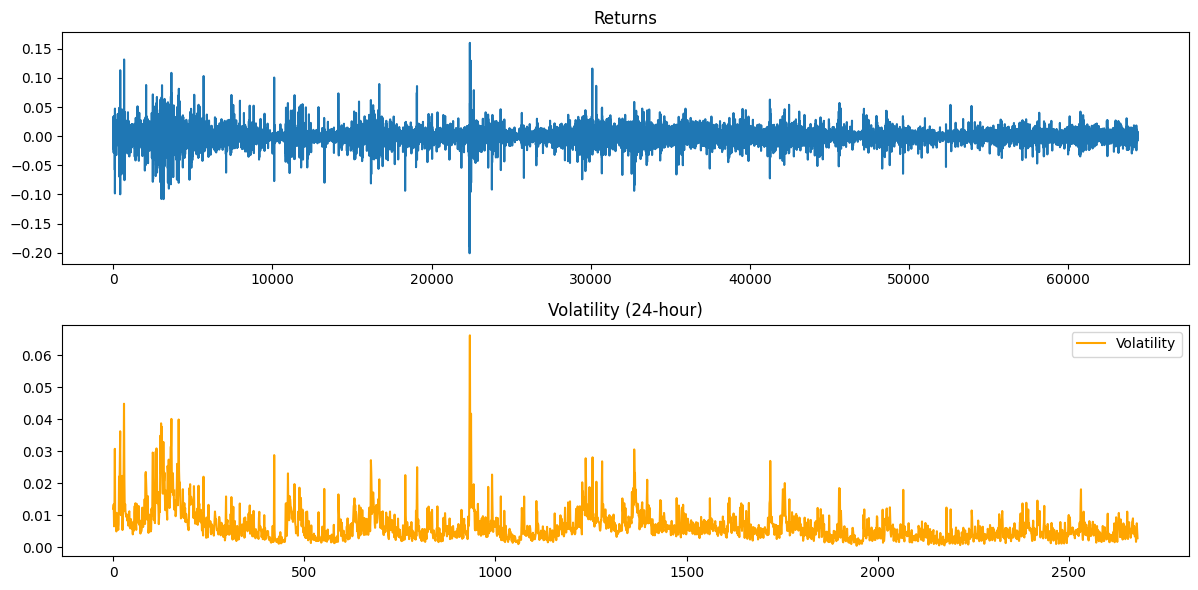

In [14]:
#W
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(returns, label="Returns")
plt.title("Returns")
plt.subplot(2, 1, 2)
plt.plot(vol, label="Volatility", color="orange")
plt.title("Volatility (24-hour)")
plt.legend()
plt.tight_layout()
plt.show()

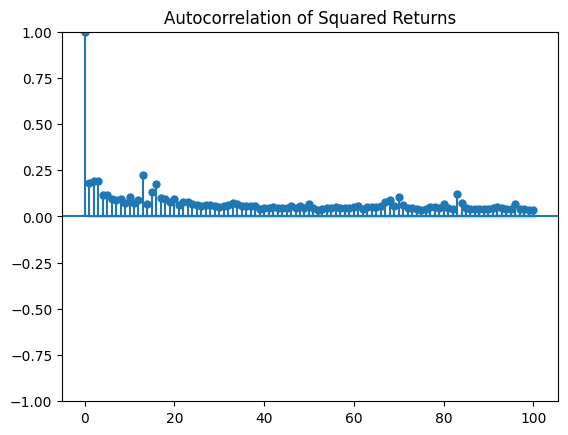

In [15]:
#Plot autocorrelation of squared returns (proxy for volatility)
plot_acf(np.square(returns), lags=100, title="Autocorrelation of Squared Returns")
plt.show()

In [16]:
#W
mean_vol = np.mean(vol)
std_vol = np.std(vol, ddof=1)
print(f"Mean Volatility: {mean_vol:.4f}")
print(f"Standard Deviation of Volatility: {std_vol:.4f}")


#Normality tests
shapiro_test = shapiro(vol)
dagostino_test = normaltest(vol)

print("Shapiro-Wilk Test:")
print(f"Statistic: {shapiro_test.statistic:.4f}, p-value: {shapiro_test.pvalue:.4f}")
print("D’Agostino and Pearson’s Test:")
print(f"Statistic: {dagostino_test.statistic:.4f}, p-value: {dagostino_test.pvalue:.4f}")

Mean Volatility: 0.0066
Standard Deviation of Volatility: 0.0050
Shapiro-Wilk Test:
Statistic: 0.7544, p-value: 0.0000
D’Agostino and Pearson’s Test:
Statistic: 1886.7085, p-value: 0.0000


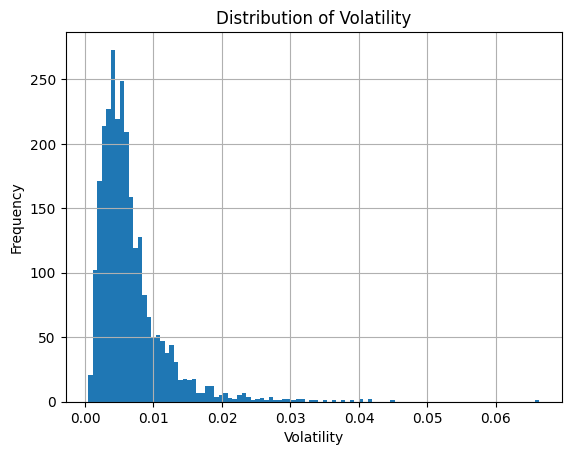

In [17]:
#W
plt.hist(vol, bins=100)
plt.title('Distribution of Volatility')
plt.xlabel('Volatility')
plt.ylabel('Frequency')
plt.grid()
plt.show()

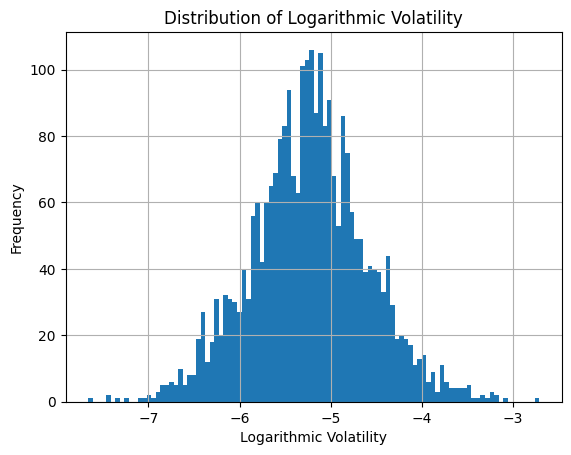

In [18]:
#W
log_vol = []

for volatility in vol:
    if volatility != 0:
        log_vol.append(np.log(volatility))
    else:
        log_vol.append(volatility)


plt.hist(log_vol, bins=100)
plt.title('Distribution of Logarithmic Volatility')
plt.xlabel('Logarithmic Volatility')
plt.ylabel('Frequency')
plt.grid()
plt.show()

<b>What are we working with?</b><br>

We have defined volatility as the standard deviation of returns over a given period of time, in this case, 24 hours. The first thing we observed when plotting both returns and volatility is that both seem to exhibit clustering. This was confirmed through the autocorrelation plot of squared returns, although it’s worth noting that this is just one measure; other metrics can be used, and autocorrelations can be analyzed similarly.

Next, we examined the mean and standard deviation of the volatility itself. Here, we observed that while the returns are already centered, the standard deviation of the volatility is significantly high compared to the mean. However, this mean is not excessively high when considering the market it pertains to, though it remains noteworthy.

Additionally, using the Shapiro-Wilk and D’Agostino tests, we confirmed that volatility does not follow a normal distribution. When plotting both the volatility and its logarithm, we found that the logarithm of volatility follows a log-normal distribution.

---

<b>The Butterfly Spread Strategy</b><br>
This strategy involves using three different strike prices: 
$K_1$, $K_2$ and $K_3$. Specifically:

Buy one call at strike price $K_1$: This gives you the right to buy the underlying asset at $K_1$<br>
Sell two calls at strike price $K_2$: You take on the obligation to sell the underlying asset at $K_2$, earning a premium for each call sold.<br>
Buy one call at strike price $K_3$: You purchase a right to buy the underlying asset at $K_3$, typically further out-of-the-money.<br>

The result is a payoff structure where you profit if the underlying asset's price ends up in the interval $[K_1;K_3]$, with the maximum profit occurring when the price is close to $K_2$.

<b>Mechanics of Options</b><br>

When you buy a call option, you pay a premium upfront. If the asset's price exceeds the strike price $K$ by more than the premium paid, you make a net profit. Otherwise, the option expires worthless, and your loss is limited to the premium.

When you sell a call option, you collect the premium upfront. If the asset’s price stays below the strike price $K$, the option expires worthless, and you keep the premium as profit. However, if the asset’s price rises above $K$, you are obligated to sell the asset at $K$, potentially incurring significant losses.

---

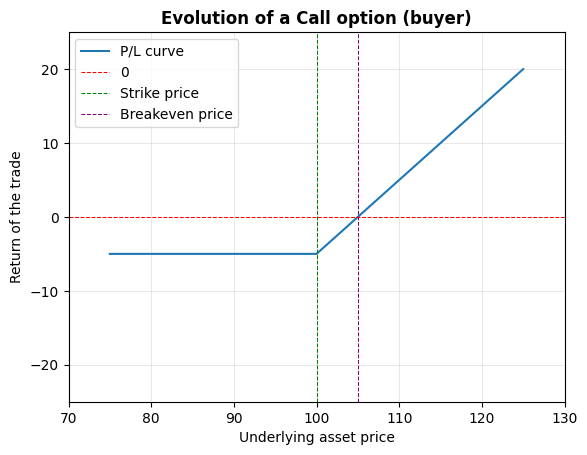

In [19]:
#E
Strike_price = 100
Asset_price = np.linspace(75, 125, 51)
Premium = 5

P_L = []

for i in Asset_price:
    if i < Strike_price:
        P_L.append(-Premium)
    else:
        Returns = i - Strike_price - Premium
        P_L.append(Returns)

plt.plot(Asset_price, P_L)
plt.title('Evolution of a Call option (buyer)', fontweight = 'bold')
plt.xlabel('Underlying asset price')
plt.ylabel('Return of the trade')
plt.ylim(-25,25)
plt.xlim(min(Asset_price) - 5, max(Asset_price) + 5)
plt.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.75)
plt.axvline(x = Strike_price, color = 'green', linestyle = '--', linewidth = 0.75)
plt.axvline(x = (Strike_price + Premium), color = 'purple', linestyle = '--', linewidth = 0.75)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5, alpha = 0.25)
plt.legend(['P/L curve', '0', 'Strike price', 'Breakeven price'])
plt.show()

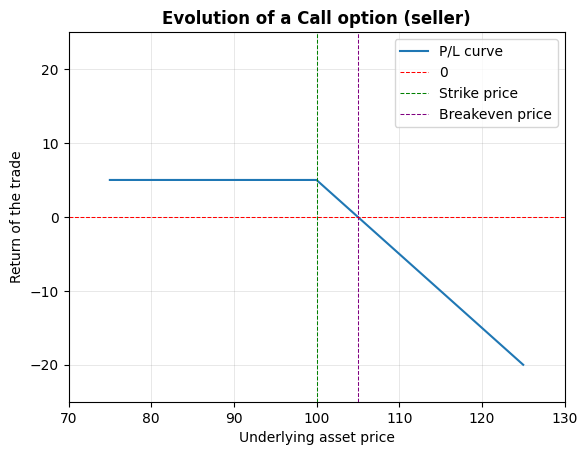

In [20]:
#E
Strike_price = 100
Asset_price = np.linspace(75, 125, 51)
Premium = 5

P_L = []

for i in Asset_price:
    if i < Strike_price:
        P_L.append(Premium)
    else:
        Returns = i - Strike_price - Premium
        P_L.append(-Returns)

plt.plot(Asset_price, P_L)
plt.title('Evolution of a Call option (seller)', fontweight = 'bold')
plt.xlabel('Underlying asset price')
plt.ylabel('Return of the trade')
plt.ylim(-25,25)
plt.xlim(min(Asset_price) - 5, max(Asset_price) + 5)
plt.axhline(y = 0, color = 'red', linestyle = '--', linewidth = 0.75)
plt.axvline(x = Strike_price, color = 'green', linestyle = '--', linewidth = 0.75)
plt.axvline(x = (Strike_price + Premium), color = 'purple', linestyle = '--', linewidth = 0.75)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5, alpha = 0.25)
plt.legend(['P/L curve', '0', 'Strike price', 'Breakeven price'])
plt.show()

As we see, the positions of the buyer and the seller are exactly the opposite, now let's do the full butterfly spread

In [21]:
#E
# Strike prices and premiums
strike_1, premium_1 = 95, 10
strike_2, premium_2 = 100, 5
strike_3, premium_3 = 105, 2

# Asset prices
asset_price = np.linspace(85, 115, 51)

# Calculate butterfly spread P/L
butterfly_return = []

for price in asset_price:
    if price < strike_1:  # Below the first strike
        single_return = -premium_1 + (2 * premium_2) - premium_3
    elif strike_1 <= price <= strike_2:  # Between strike_1 and strike_2
        single_return = (price - strike_1 - premium_1) + (2 * premium_2) - premium_3
    elif strike_2 < price < strike_3:  # Between strike_2 and strike_3
        single_return = (price - strike_1 - premium_1) + (2 * premium_2 - 2 * (price - strike_2)) - premium_3
    else:  # Above the third strike
        single_return = (price - strike_1 - premium_1) + (2 * premium_2 - 2 * (price - strike_2)) + (price - strike_3 - premium_3)
    butterfly_return.append(single_return)

# Net cost of the butterfly spread
net_cost = premium_1 - 2 * premium_2 + premium_3

# Break-even points
breakeven_1 = strike_1 + net_cost
breakeven_2 = strike_3 - net_cost

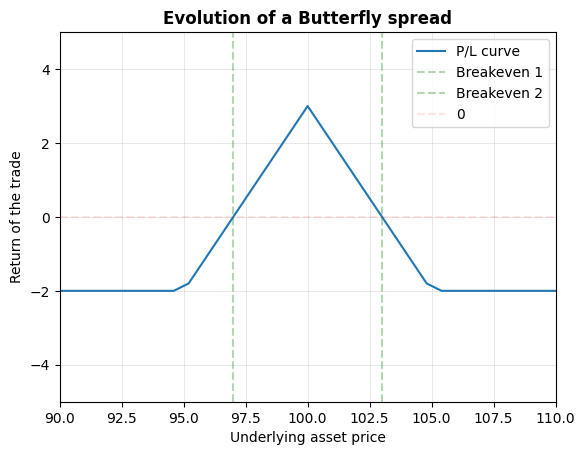

In [22]:
plt.plot(asset_price, butterfly_return)
plt.title('Evolution of a Butterfly spread', fontweight = 'bold')
plt.xlabel('Underlying asset price')
plt.ylabel('Return of the trade')
plt.axvline(x = breakeven_1, color = 'green', alpha = 0.30, linestyle = '--')
plt.axvline(x = breakeven_2, color = 'green', alpha = 0.30, linestyle = '--')
plt.axhline(y = 0, color = 'red', alpha = 0.10, linestyle = '--')
plt.ylim(-5,5)
plt.xlim(90,110)
plt.grid(color = 'grey', linestyle = '-', linewidth = 0.5, alpha = 0.25)
plt.legend(['P/L curve', 'Breakeven 1', 'Breakeven 2', '0'])
plt.show()

Please note that, even though the chart seems to be bigger than needed, the X-axis shows a $\pm10$% in the underlying asset price, and the breakeven zone is in a $\pm3$% range, which for short term operations is quite big.

In [23]:
#W
def fetch_options_data(url, currency, kind):
    params = {
        'currency' : currency,
        'kind' : kind,
        'expired' : 'true'
    }
    
    response = requests.get(url, params)
    options_data = response.json()

    return options_data.get('result',[])

def filter_options_data(options_data, target_date):
    '''
    Be **EXTREMELY** cautious on how is formated the data after getting it.
    '''
    start_of_day = int(time.mktime(time.strptime(target_date, "%Y-%m-%d")) * 1000)
    end_of_day = start_of_day + (24 * 60 * 60 * 1000) - 1  # End of the day in milliseconds
    filtered_data = [opt for opt in options_data if start_of_day <= opt["expiration_timestamp"] <= end_of_day]
    return filtered_data

In [24]:
#W
currency = 'BTC'
kind = 'option'
options_url = 'https://history.deribit.com/api/v2/public/get_instruments'

options_data = fetch_options_data(options_url, currency, kind)

with open('Options data from 15JUL2016-BTC.json', 'w') as f:
    json.dump(options_data, f)

In [25]:
#E
with open('Options data from 15JUL2016-BTC.json', 'r') as f:
    options_data = json.load(f)

options_data[0]

{'tick_size_steps': [],
 'tick_size': 0.0001,
 'taker_commission': 0.0001,
 'strike': 600.0,
 'settlement_period': 'week',
 'settlement_currency': 'BTC',
 'rfq': False,
 'quote_currency': 'BTC',
 'price_index': 'btc_usd',
 'option_type': 'call',
 'min_trade_amount': 0.01,
 'maker_commission': 0.0,
 'kind': 'option',
 'is_active': False,
 'instrument_name': 'BTC-15JUL16-600-C',
 'instrument_id': 70492,
 'expiration_timestamp': 1468594800000,
 'creation_timestamp': 1468453919000,
 'counter_currency': 'USD',
 'contract_size': 1.0,
 'block_trade_tick_size': 0.0001,
 'block_trade_min_trade_amount': 50,
 'block_trade_commission': 0.00015,
 'base_currency': 'BTC'}

In [26]:
#E
target_date = '2024-11-22'

filtered_options = filter_options_data(options_data, target_date)

print(f"Found {len(filtered_options)} options expiring on {target_date}.")
for opt in filtered_options[:1]:  # Show the first x for inspection
    print(opt)

Found 110 options expiring on 2024-11-22.
{'tick_size_steps': [{'tick_size': 0.0005, 'above_price': 0.005}], 'tick_size': 0.0001, 'taker_commission': 0.0003, 'strike': 56000.0, 'settlement_period': 'week', 'settlement_currency': 'BTC', 'rfq': False, 'quote_currency': 'BTC', 'price_index': 'btc_usd', 'option_type': 'call', 'min_trade_amount': 0.1, 'maker_commission': 0.0003, 'kind': 'option', 'is_active': False, 'instrument_name': 'BTC-22NOV24-56000-C', 'instrument_id': 385097, 'expiration_timestamp': 1732262400000, 'creation_timestamp': 1730383380000, 'counter_currency': 'USD', 'contract_size': 1.0, 'block_trade_tick_size': 0.0001, 'block_trade_min_trade_amount': 50, 'block_trade_commission': 0.0003, 'base_currency': 'BTC'}


Up till here, I've just been demonstrating the data we have, how we will measure the strategy returns, the dates, and the evaluation, from now on the work will be done in the next areas, not by order:<br><br>
- Define the strategy not in full butterfly spreads, but rather in a group of options; this mean I won't be neccesary operating with buying 1 Call, selling 2 Calls and buying another Call, but maybe adding one call or more in one group or another, reflecting how my views are at the moment, e.i. if I think that price is gonna increase even with low volatility, I may buy 2 Calls at the third strike rather than only one.<br>
- Viability test; even before creating the model, I will take some periods with low vol (from the data of course), and check the price in t+1 (being t the moment that vol is low), and checking if the price is in the range we will define for the operation. (Between K1 and K3)<br>
- Creating the model; here I don't have much to say, I will code a GARCH model to test it, and then by trial and error we will see the automated results.

In [27]:
#W
def buy_call(strike_price, premium, asset_price):
    if asset_price > strike_price:
        result = asset_price - strike_price - premium
    else: 
        result = - premium
    return result
def sell_call(strike_price, premium, asset_price):
    if asset_price > strike_price:
        result = - asset_price + strike_price + premium
    else: 
        result = + premium
    return result
def buy_put(strike_price, premium, asset_price):
    if asset_price < strike_price:
        result = - asset_price + strike_price - premium
    else: 
        result = - premium
    return result
def sell_put(strike_price, premium, asset_price):
    if asset_price > strike_price:
        result = + asset_price - strike_price + premium
    else: 
        result = + premium
    return result

In [28]:
#W
df = pd.DataFrame(data_dict)

# Convert UNIX time to datetime
df['Datetime'] = pd.to_datetime(df['Time'], unit='ms')
df.set_index('Datetime', inplace=True)
df = df.sort_index()
df['Datetime'] = pd.to_datetime(df['Time'], unit='ms')

#Creating the needed columns in the df:
df['Log_returns'] = np.log(df['Close']/df['Close'].shift(1))
df.loc[df['Close'] == 0, 'Log_returns'] = np.log(df.loc[df['Close'] == 0, 'Close'] / df.loc[df['Close'] == 0, 'Open'])
df.loc[df.index[0], 'Log_returns'] = np.log(df['Close'].iloc[0] / df['Open'].iloc[0])

df['Volatility'] = df['Log_returns'].rolling(window=24).std()
df['Log_Volatility'] = np.log(df['Volatility'])

df = df.dropna()

rolling_window = 24
static_percentile_20 = np.percentile(df['Log_Volatility'], 20)
df['Signal'] = (df['Log_Volatility'] < static_percentile_20).astype(int)

In [29]:
#E
count = 0

for i in range(len(df['Signal'])):
    if df['Signal'].iloc[i] != 0:
        count += 1
n_data = len(df)

print(f'How many data we have: {n_data}, How many signals we have: {count}')

How many data we have: 64337, How many signals we have: 12868


Of course, because of how this volatility is measured, most of the signals will be really close to one another, they will be in chunks, resulting in fewer operations, so lets resolve that.

In [30]:
#W
time_condition = (df['Datetime'].dt.hour >= 5) & (df['Datetime'].dt.hour <= 11)
filtered_df = df[time_condition].copy()

# Recalculate the volatility and signals at these intervals
filtered_df.loc[:, 'Signal'] = (filtered_df['Log_Volatility'] < static_percentile_20).astype(int)

In [31]:
#W
filtered_df['Date'] = filtered_df['Datetime'].dt.date
signal_days = filtered_df.loc[filtered_df['Signal'] == 1, 'Date'].unique()# Unique days with signals
signal_days = [day if isinstance(day, date) else datetime.strptime(day, "%Y-%m-%d").date() for day in signal_days]
signal_days = sorted(signal_days)

In [32]:
#W

#It seems I have overwritten the module datetime, so I will call it again.
from datetime import datetime, timedelta

options_filtered = [
    option for option in options_data
    if datetime.utcfromtimestamp(option['expiration_timestamp'] / 1000).hour == 8 and option['option_type'] == 'call'
]

for option in options_filtered:
    option['expiration_date'] = datetime.utcfromtimestamp(option['expiration_timestamp'] / 1000).date()

In [33]:
options_filtered[0]

{'tick_size_steps': [],
 'tick_size': 0.0001,
 'taker_commission': 0.0001,
 'strike': 700.0,
 'settlement_period': 'week',
 'settlement_currency': 'BTC',
 'rfq': False,
 'quote_currency': 'BTC',
 'price_index': 'btc_usd',
 'option_type': 'call',
 'min_trade_amount': 0.01,
 'maker_commission': 0.0001,
 'kind': 'option',
 'is_active': False,
 'instrument_name': 'BTC-2DEC16-700-C',
 'instrument_id': 141058,
 'expiration_timestamp': 1480665600000,
 'creation_timestamp': 1480084980000,
 'counter_currency': 'USD',
 'contract_size': 1.0,
 'block_trade_tick_size': 0.0001,
 'block_trade_min_trade_amount': 50,
 'block_trade_commission': 0.00015,
 'base_currency': 'BTC',
 'expiration_date': datetime.date(2016, 12, 2)}

In [34]:
#W
import datetime
test_condition = (filtered_df['Datetime'].dt.hour == 8)
test_df = filtered_df[test_condition].copy()
test_df.drop(columns = ['Open', 'High', 'Low', 'Volume', 'Log_returns', 'Volatility', 'Signal', 'Date'], inplace = True)
test_df['Datetime'] = pd.to_datetime(test_df['Datetime']).dt.date

test_df['Next_day_Datetime'] = test_df['Datetime'].shift(-1)
test_df['Next_day_Close'] = test_df['Close'].shift(-1)
test_df['Move'] = (test_df['Next_day_Close']/test_df['Close'] -1) * 100

test_df['Next_day_Datetime_2'] = test_df['Datetime'].shift(-2)
test_df['Next_day_Close_2'] = test_df['Close'].shift(-2)
test_df['Move_2'] = (test_df['Next_day_Close_2']/test_df['Close'] -1) * 100

filtered_date = int(datetime.datetime(2020,6,1).timestamp() * 1000)
test_df = test_df[test_df['Time'] > filtered_date]

test_df = test_df[test_df['Datetime'].isin(signal_days)]

In [35]:
test_df.head(-5)

,Time,Close,Datetime,Log_Volatility,Next_day_Datetime,Next_day_Close,Move,Next_day_Datetime_2,Next_day_Close_2,Move_2
Datetime,,,,,,,,,,
2020-06-01 08:00:00,1.590998e+12,9540.30,2020-06-01,-5.710468,2020-06-02,10107.48,5.945096,2020-06-03,9507.00,-0.349046
2020-06-04 08:00:00,1.591258e+12,9642.22,2020-06-04,-5.957024,2020-06-05,9833.43,1.983050,2020-06-06,9605.10,-0.384974
2020-06-06 08:00:00,1.591430e+12,9605.10,2020-06-06,-5.656372,2020-06-07,9661.31,0.585210,2020-06-08,9689.99,0.883801
2020-06-07 08:00:00,1.591517e+12,9661.31,2020-06-07,-5.939136,2020-06-08,9689.99,0.296854,2020-06-09,9683.46,0.229265
2020-06-09 08:00:00,1.591690e+12,9683.46,2020-06-09,-5.753577,2020-06-10,9739.00,0.573555,2020-06-11,9803.12,1.235715
...,...,...,...,...,...,...,...,...,...,...
2024-10-25 08:00:00,1.729843e+12,67658.50,2024-10-25,-5.889377,2024-10-26,67134.65,-0.774256,2024-10-27,67226.00,-0.639240
2024-10-27 08:00:00,1.730016e+12,67226.00,2024-10-27,-6.584340,2024-10-28,68328.00,1.639247,2024-10-29,71134.01,5.813242
2024-10-28 08:00:00,1.730102e+12,68328.00,2024-10-28,-6.037605,2024-10-29,71134.01,4.106677,2024-10-30,72241.35,5.727301


In [36]:
#W
correct = 0
incorrect = 0

for i in range(len(test_df['Move'])):
    if test_df['Move'].iloc[i] > 5 or test_df['Move'].iloc[i] < -5:
        incorrect += 1
    else:
        correct += 1

print(correct, incorrect)

384 21


So, this being done the 27th of November 2024, at 12:11 UTC, I got 378 correct and 21 incorrect for a move under 5%, needless to say, an impressive result, I knew volatility was clustered, but not <b>that</b> clustered, also, this doesn't mean I would have got any profitable operation said day, we need to account for fees, for the fact that returns in operations are not constant, (as depicted for the explanation of how a butterfly spread works), and more, maybe a call at 95% of the price the time I saw the signal wasn't available, maybe is was so expensive it took all profit, we don't know. The data is from the first of June of 2020 because if we use earlier data, there may not be options data for that concrete day or strike or expiration date. <br><br>
Now, there are two ways to compute the real achievable prediction capability of this strategy, there are; the way I'm not gonna do and the one I'm gonna do.<br>
- What I could do (but no going to do it): is to take the days that I get a "late signal", this is, when the signals starts at 05:00 and it maintains, or it starts after 05:00 but it maintains, and when I get in two continuous hours the signal I evaluate the option prices and simulate the operation with all costs.
- What I am gonna do: If a day got a signal, evaluate option prices at 08:00 and simulate costs and operation.<br><br>
The first way, even though more precise (but not by much) is literally over-enginering things, I don't need to check every hour, more so with the amount of data I'm going to work with, i.e. for each day (603 days) get the instrument at Close price, at 0.95 Close price and 1.05 Close price, and for each instrument, get the whole traded data of the last 26 hours before expiration, get the prices at the 24th hour before expiration, check there is avaibility of the options I want to buy/sell, check prices, if there is no options at that price get price at 0.96 Close or 1.04 Close, repeat... And all that to model performance, then is needed real-time implementation, or, in business lingo "send the model to production".

To end or to perform some other initial analysis, and, depending on the future performance of the predictions, one could change the lookahead time from 24 hours, the current value, to more or less, in fact, the earlier we predict the low volatility, the more range for profit we can get from the strategy, since option prices, when the expiration time is close, tend to be more acurrate, leaving less room for arbitrage.

In [37]:
correct = 0
incorrect = 0

for i in range(len(test_df['Move_2'])):
    if test_df['Move_2'].iloc[i] > 3 or test_df['Move_2'].iloc[i] < -3:
        incorrect += 1
    else:
        correct += 1

print(correct, incorrect)

304 101


As we see, with a 48 hour look ahead, and a smaller prediction range $\pm3$%, we still get about $\frac{298}{298+101} = 59,71$% right predictions, or, rather than predictions, we see that the pattern is followed 59,71% of the time.

In [38]:
#W
look_ahead_24 = set(test_df['Time'] + 24*60*60*1000)
look_ahead_48 = set(test_df['Time'] + 48*60*60*1000)

options_test_24h = [
    option for option in options_data
    if option['expiration_timestamp'] in look_ahead_24
]

options_test_48h = [
    option for option in options_data
    if option['expiration_timestamp'] in look_ahead_48
]

In [39]:
#W
options_test_24h = [
    option for option in options_test_24h
    if (option['expiration_timestamp'] - 24*60*60*1000) in test_df['Time'].values
    and (
        (test_df.loc[test_df['Time'] == (option['expiration_timestamp'] - 24*60*60*1000), 'Close'].iloc[0] * 0.949 < option['strike'])
        and
        (test_df.loc[test_df['Time'] == (option['expiration_timestamp'] - 24*60*60*1000), 'Close'].iloc[0] * 1.051 > option['strike'])
    )
]

options_test_48h = [
    option for option in options_test_48h
    if (option['expiration_timestamp'] - 48*60*60*1000) in test_df['Time'].values
    and (
        (test_df.loc[test_df['Time'] == (option['expiration_timestamp'] - 48*60*60*1000), 'Close'].iloc[0] * 0.949 < option['strike'])
        and
        (test_df.loc[test_df['Time'] == (option['expiration_timestamp'] - 48*60*60*1000), 'Close'].iloc[0] * 1.051 > option['strike'])
    )
]

In [40]:
#W
#Dictionary to group options by signal day
options_by_day_24h = defaultdict(list)
options_by_day_48h = defaultdict(list)

#Group options by expiration_timestamp - 24 hours (signal day timestamp)
for option in options_test_24h:
    signal_day_timestamp =(option['expiration_timestamp'] - 24*60*60*1000)
    options_by_day_24h[signal_day_timestamp].append(option)

#Group options by expiration_timestamp - 48 hours (signal day timestamp)
for option in options_test_48h:
    signal_day_timestamp =(option['expiration_timestamp'] - 48*60*60*1000)
    options_by_day_48h[signal_day_timestamp].append(option)

In [41]:
#W
#Result structure for the butterfly spread options
butterfly_options_24h = {}

#Iterate over grouped options
for signal_timestamp, options in options_by_day_24h.items():
    #Safely get the Close price for the signal day
    close_price_series = test_df.loc[test_df['Time'] == signal_timestamp, 'Close']
    
    if close_price_series.empty:
        print(f"Warning: No Close price found for signal timestamp {signal_timestamp}")
        continue  #Skip this signal day if no matching Close price exists
    
    close_price = close_price_series.iloc[0]  #Safely extract the first matching value

    #Find the option with the strike closest to the close price
    closest_option = min(options, key=lambda x: abs(x['strike'] - close_price))

    #Find the option with the lowest strike
    lowest_option = min(options, key=lambda x: x['strike'])

    #Find the option with the highest strike
    highest_option = max(options, key=lambda x: x['strike'])

    #Store the selected options for the day
    butterfly_options_24h[signal_timestamp] = {
        'closest_option': closest_option,
        'lowest_option': lowest_option,
        'highest_option': highest_option
    }

butterfly_options_48h = {}

#Iterate over grouped options
for signal_timestamp, options in options_by_day_48h.items():
    #Safely get the Close price for the signal day
    close_price_series = test_df.loc[test_df['Time'] == signal_timestamp, 'Close']
    
    if close_price_series.empty:
        print(f"Warning: No Close price found for signal timestamp {signal_timestamp}")
        continue  #Skip this signal day if no matching Close price exists
    
    close_price = close_price_series.iloc[0]  #Safely extract the first matching value

    #Find the option with the strike closest to the close price
    closest_option = min(options, key=lambda x: abs(x['strike'] - close_price))

    #Find the option with the lowest strike
    lowest_option = min(options, key=lambda x: x['strike'])

    #Find the option with the highest strike
    highest_option = max(options, key=lambda x: x['strike'])

    #Store the selected options for the day
    butterfly_options_48h[signal_timestamp] = {
        'closest_option': closest_option,
        'lowest_option': lowest_option,
        'highest_option': highest_option
    }

In [42]:
len(butterfly_options_48h)

404

So, for a 48h look ahead, there are 399 combinations of butterfly spreads, now we have to retrieve from the API each one of the three options present in each butterfly combination, get the data for the 48th (in my case) hour before, and simulate the portfolio.

In [43]:
butterfly_options_48h

{1590998400000: {'closest_option': {'tick_size_steps': [],
   'tick_size': 0.0001,
   'taker_commission': 0.0004,
   'strike': 9500.0,
   'settlement_period': 'day',
   'settlement_currency': 'BTC',
   'rfq': False,
   'quote_currency': 'BTC',
   'price_index': 'btc_usd',
   'option_type': 'call',
   'min_trade_amount': 0.01,
   'maker_commission': 0.0004,
   'kind': 'option',
   'is_active': False,
   'instrument_name': 'BTC-3JUN20-9500-C',
   'instrument_id': 69519,
   'expiration_timestamp': 1591171200000,
   'creation_timestamp': 1590998412000,
   'counter_currency': 'USD',
   'contract_size': 1.0,
   'block_trade_tick_size': 0.0001,
   'block_trade_min_trade_amount': 50,
   'block_trade_commission': 0.00015,
   'base_currency': 'BTC',
   'expiration_date': datetime.date(2020, 6, 3)},
  'lowest_option': {'tick_size_steps': [],
   'tick_size': 0.0001,
   'taker_commission': 0.0004,
   'strike': 9125.0,
   'settlement_period': 'day',
   'settlement_currency': 'BTC',
   'rfq': False,


In [44]:
#E
instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

asdf = 1590998400000
asfd = 1590998400000 +24*60*60*1000

params = {
    'instrument_name' : 'BTC-3JUN20-9500-C',
    'start_timestamp' : asdf,
    'count' : 2,
    'sorting' : 'asc'
}

response = requests.get(instruments_url, params)
example_instrument_data = response.json()

In [45]:
example_instrument_data

{'usOut': 1735852043268136,
 'usIn': 1735852043262682,
 'usDiff': 5454,
 'testnet': False,
 'result': {'trades': [{'trade_seq': 1,
    'trade_id': '80833624',
    'timestamp': 1591044310596,
    'tick_direction': 1,
    'price': 0.0245,
    'mark_price': 0.02359031,
    'iv': 63.22,
    'instrument_name': 'BTC-3JUN20-9500-C',
    'index_price': 9647.15,
    'direction': 'buy',
    'amount': 7.0},
   {'trade_seq': 2,
    'trade_id': '80865679',
    'timestamp': 1591052737257,
    'tick_direction': 0,
    'price': 0.059,
    'mark_price': 0.05423351,
    'iv': 99.92,
    'instrument_name': 'BTC-3JUN20-9500-C',
    'index_price': 10026.05,
    'direction': 'buy',
    'amount': 0.1}],
  'has_more': True},
 'jsonrpc': '2.0'}

In [46]:
#W
#Function to check for trades
def has_trades(instrument_name, start_timestamp, end_timestamp):
    instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

    params = {
        'instrument_name': instrument_name,
        'start_timestamp': start_timestamp,
        'end_timestamp': end_timestamp,
        'count': 25,  # Adjust as needed
        'sorting': 'asc'
    }

    response = requests.get(instruments_url, params=params)
    data = response.json()
    trades = data.get('result', {}).get('trades', [])

    return len(trades) > 0

#Time window calculation (48 to 24 hours before expiration)
def get_time_window(expiration_timestamp):
    end_timestamp = expiration_timestamp - 24 * 60 * 60 * 1000  # 24 hours before expiration
    start_timestamp = expiration_timestamp - 48 * 60 * 60 * 1000  # 48 hours before expiration
    return start_timestamp, end_timestamp

In [47]:
#W
cleaned_butterfly_options_24h = {}
cleaned_butterfly_options_48h = {}

for day, options in butterfly_options_24h.items():
    valid_options = {}
    for option_type, option_data in options.items():
        instrument_name = option_data['instrument_name']
        expiration_timestamp = option_data['expiration_timestamp']

        # Get the time window for trades
        start_timestamp, end_timestamp = get_time_window(expiration_timestamp)

        # Check for trades
        if has_trades(instrument_name, start_timestamp, end_timestamp):
            valid_options[option_type] = option_data

    # If all three options are valid, add the day to the cleaned spread
    if len(valid_options) == 3:
        cleaned_butterfly_options_24h[day] = valid_options
        
for day, options in butterfly_options_48h.items():
    valid_options = {}
    for option_type, option_data in options.items():
        instrument_name = option_data['instrument_name']
        expiration_timestamp = option_data['expiration_timestamp']

        # Get the time window for trades
        start_timestamp, end_timestamp = get_time_window(expiration_timestamp)

        # Check for trades
        if has_trades(instrument_name, start_timestamp, end_timestamp):
            valid_options[option_type] = option_data

    # If all three options are valid, add the day to the cleaned spread
    if len(valid_options) == 3:
        cleaned_butterfly_options_48h[day] = valid_options

As there are days in whose options haven't been traded (at least some option of the three needed) we need to filter out those days, leaving us with only the days in which the three options have been traded. This is important for the option price, if there's no historical trade of said option, there's no price, and, while it's true we can get the price with some other option pricing model, that would be overengineering again, and, for bigger structures it may be needed, more precision, here there's no need, we are looking up prices, if there's no price, there's no day.

In [48]:
#W

# Define API endpoint
instruments_url = 'https://history.deribit.com/api/v2/public/get_last_trades_by_instrument_and_time'

#Time window constants (48h - 24h before expiration)
TIME_BEFORE_EXPIRATION = 48 * 60 * 60 * 1000  #milliseconds
TIME_AFTER_START = 24 * 60 * 60 * 1000

#Function to get trade data for an option
def fetch_trade_data(instrument_name, start_timestamp):
    params = {
        'instrument_name': instrument_name,
        'start_timestamp': start_timestamp,
        'count': 5,  #Fetch up to 5 trades (adjust if needed)
        'sorting': 'asc'
    }
    try:
        response = requests.get(instruments_url, params)
        data = response.json()
        if 'result' in data and 'trades' in data['result']:
            return data['result']['trades']
    except Exception as e:
        print(f"Error fetching data for {instrument_name}: {e}")
    return []

#Function to calculate trade price
def calculate_price(trades):
    if not trades:
        return None  # No trades available
    prices = [trade['price'] * trade['index_price'] for trade in trades]
    return sum(prices) / len(prices) if prices else None  # Mean price of trades

In [49]:
#W
#Process each day in cleaned_butterfly_options_48h
for day, options in cleaned_butterfly_options_48h.items():
    for key in ['lowest_option', 'closest_option', 'highest_option']:
        option = options[key]
        instrument_name = option['instrument_name']
        expiration_timestamp = option['expiration_timestamp']
        
        #Calculate time window
        start_timestamp = expiration_timestamp - TIME_BEFORE_EXPIRATION
        end_timestamp = expiration_timestamp - TIME_AFTER_START
        
        #Fetch trades
        trades = fetch_trade_data(instrument_name, start_timestamp)
        time.sleep(0.1)  #Pause to respect API limits
        
        #Calculate price
        trade_price = calculate_price(trades)
        if trade_price is not None:
            option['trade_price'] = trade_price
        else:
            option['trade_price'] = None  #No valid price found

In [50]:
#W
'''
cost_of_entry = (
    (1 * lowest_price * (1 + taker_commission))  # Buy 1 Lowest Strike Option
    + (2 * closest_price * (1 - maker_commission))  # Sell 2 Closest Strike Options
    + (1 * highest_price * (1 + taker_commission))  # Buy 1 Highest Strike Option
)

payoff = max(0, S - lowest_strike) - 2 * max(0, S - closest_strike) + max(0, S - highest_strike)

return_value = payoff - cost_of_entry
'''

'\ncost_of_entry = (\n    (1 * lowest_price * (1 + taker_commission))  # Buy 1 Lowest Strike Option\n    + (2 * closest_price * (1 - maker_commission))  # Sell 2 Closest Strike Options\n    + (1 * highest_price * (1 + taker_commission))  # Buy 1 Highest Strike Option\n)\n\npayoff = max(0, S - lowest_strike) - 2 * max(0, S - closest_strike) + max(0, S - highest_strike)\n\nreturn_value = payoff - cost_of_entry\n'

In [51]:
#W
def calculate_butterfly_return(day, options, spot_price_at_expiration):
    """
    Calculate the return for a butterfly spread on a given day.
    
    Arguments:
    - day: The key date of the butterfly spread (not expiration).
    - options: A dictionary containing the option details (lowest, closest, highest).
    - spot_price_at_expiration: The spot price at expiration.
    
    Returns:
    - Dictionary with cost, payoff, and final return.
    """
    #Extract option details
    lowest_option = options['lowest_option']
    closest_option = options['closest_option']
    highest_option = options['highest_option']
    
    #Extract prices and commissions
    lowest_price = lowest_option['trade_price']
    closest_price = closest_option['trade_price']
    highest_price = highest_option['trade_price']
    
    taker_commission_lowest = lowest_option['taker_commission']
    maker_commission = closest_option['maker_commission']
    taker_commission_highest = highest_option['taker_commission']
    
    lowest_strike = lowest_option['strike']
    closest_strike = closest_option['strike']
    highest_strike = highest_option['strike']
    
    #Calculate cost of entry
    cost_of_entry = (
        (1 * lowest_price * (1 + taker_commission_lowest))  # Long 1 Lowest Strike
        - (2 * closest_price * (1 - maker_commission))  # Short 2 Closest Strike
        + (1 * highest_price * (1 + taker_commission_highest))  # Long 1 Highest Strike
    )
    
    #Calculate payoff at expiration
    payoff = (
        max(0, spot_price_at_expiration - lowest_strike)
        - 2 * max(0, spot_price_at_expiration - closest_strike)
        + max(0, spot_price_at_expiration - highest_strike)
    )
    
    #Calculate final return
    return_value = payoff - cost_of_entry
    
    #Return results as a dictionary
    return {
        'cost_of_entry': cost_of_entry,
        'payoff': payoff,
        'return': return_value
    }


In [52]:
test_df.iloc[0]

Time                   1590998400000.0
Close                           9540.3
Datetime                    2020-06-01
Log_Volatility               -5.710468
Next_day_Datetime           2020-06-02
Next_day_Close                10107.48
Move                          5.945096
Next_day_Datetime_2         2020-06-03
Next_day_Close_2                9507.0
Move_2                       -0.349046
Name: 2020-06-01 08:00:00, dtype: object

In [76]:
#W
#Process all butterfly spreads
results = {}
for day, options in cleaned_butterfly_options_48h.items():
    # Get spot price at expiration from test_df
    spot_price_at_expiration = test_df.loc[test_df['Time'] == day, 'Next_day_Close_2'].values[0]
    
    # Calculate the return for the butterfly spread
    result = calculate_butterfly_return(day, options, spot_price_at_expiration)
    results[day] = result

In [77]:
for timestamp, values in results.items():
    cost = values["cost_of_entry"]
    ret = values["return"]

    # Apply the conditions sequentially
    if cost > 1000:
        values["return"] = ret / 5
        values["cost_of_entry"] = cost / 5 
    elif cost < 201:
        values["return"] = ret * 5
        values["cost_of_entry"] = cost * 5
    elif cost < 251:
        values["return"] = ret * 4
        values["cost_of_entry"] = cost * 4
    elif cost < 351:
        values["return"] = ret * 3
        values["cost_of_entry"] = cost * 3
    elif cost < 501:
        values["return"] = ret * 2
        values["cost_of_entry"] = cost * 2

In [78]:
positive_costs = [values["cost_of_entry"] for values in results.values() if values["cost_of_entry"] > 0]
mean_positive_cost = mean(positive_costs) if positive_costs else 0  # Handle empty list case

# Print the result
print(f"The mean cost of entry (excluding negatives) is: {mean_positive_cost}")

The mean cost of entry (excluding negatives) is: 664.8711474987982


In [79]:
results

{1591776000000: {'cost_of_entry': 526.9732960959999,
  'payoff': 224.71999999999935,
  'return': 596.6267039039968},
 1591862400000: {'cost_of_entry': -747.4604376259998,
  'payoff': 65.01000000000022,
  'return': 1072.510437626001},
 1592121600000: {'cost_of_entry': -500.59056936000025,
  'payoff': 258.8700000000008,
  'return': 1794.9405693600042},
 1592553600000: {'cost_of_entry': 878.1395993571999,
  'payoff': 487.8099999999995,
  'return': 585.2904006427985},
 1592640000000: {'cost_of_entry': 611.2240363199999,
  'payoff': 192.79999999999927,
  'return': 352.7759636799965},
 1592726400000: {'cost_of_entry': 975.2066661252,
  'payoff': 139.97999999999956,
  'return': -555.2666661252013},
 1592985600000: {'cost_of_entry': -221.02394184600018,
  'payoff': 0,
  'return': 221.02394184600018},
 1593244800000: {'cost_of_entry': 129.15785027399988,
  'payoff': 344.7099999999991,
  'return': 1594.3921497259958},
 1593504000000: {'cost_of_entry': 926.0911947079994,
  'payoff': 291.549999999

In [80]:
#W
negative_return_days = 0
positive_days = 0

for k, v in results.items():
    if v['return'] < 0:
        negative_return_days += 1
    else:
        positive_days += 1

print(positive_days, negative_return_days)

82 34


In [81]:
#W
cumulative_returns=0

for k, v in results.items():
    cumulative_returns+=v['return']

cumulative_returns

131998.92910237095

So... This is it, for our predictions, starting the first of June, 2020, we have made 113 operations, 79 of which where positive, and 34 negative, making a total of $12.766$€ in profit along this time, about 4 years and a half. It's important to note a couple of things, this is with one contract per option, meaning, for bigger portfolios, the results would be bigger, its proportional, and that some of the earliest operations have a bigger error margin than desired, this for the fact that, or there is not enough data, or the data is split long the timeframe, and not in the single point we would want it to, or spread measures, slippage and other metrics. Now lets represent the portfolio path along time

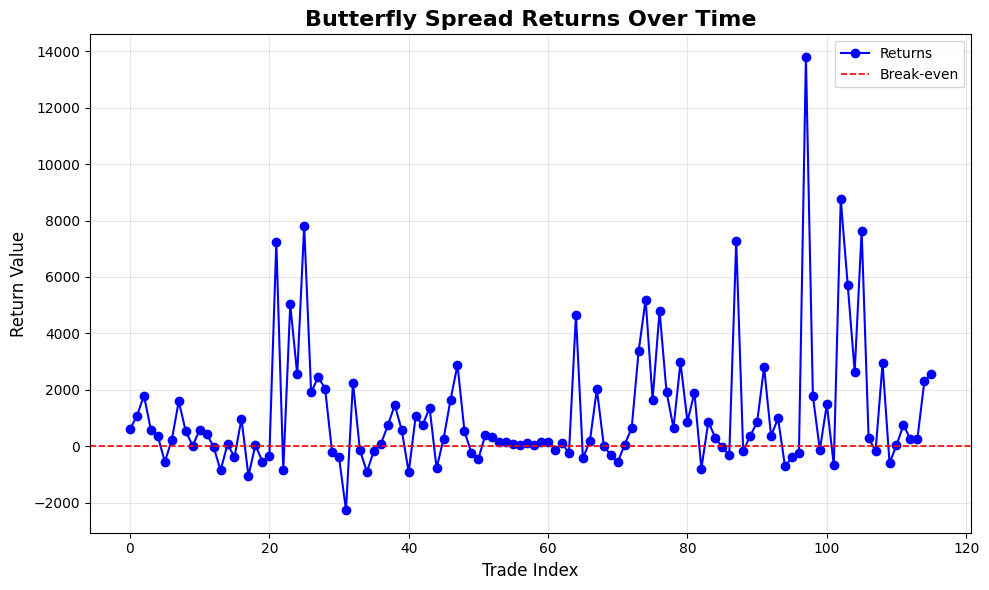

In [82]:
#W
portfolio = 10000
returns = []

for k, v in results.items():
    portfolio += v['return']
    returns.append(v['return'])

plt.figure(figsize=(10, 6))
plt.plot(returns, marker='o', linestyle='-', color='b', label="Returns")
plt.axhline(0, color='red', linestyle='--', linewidth=1.2, label="Break-even")
plt.title("Butterfly Spread Returns Over Time", fontsize=16, weight="bold")
plt.xlabel("Trade Index", fontsize=12)
plt.ylabel("Return Value", fontsize=12)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

The returns gets higher in magnitude as BTC price increases, because options prices and returns are directly linked to the underlying asset price

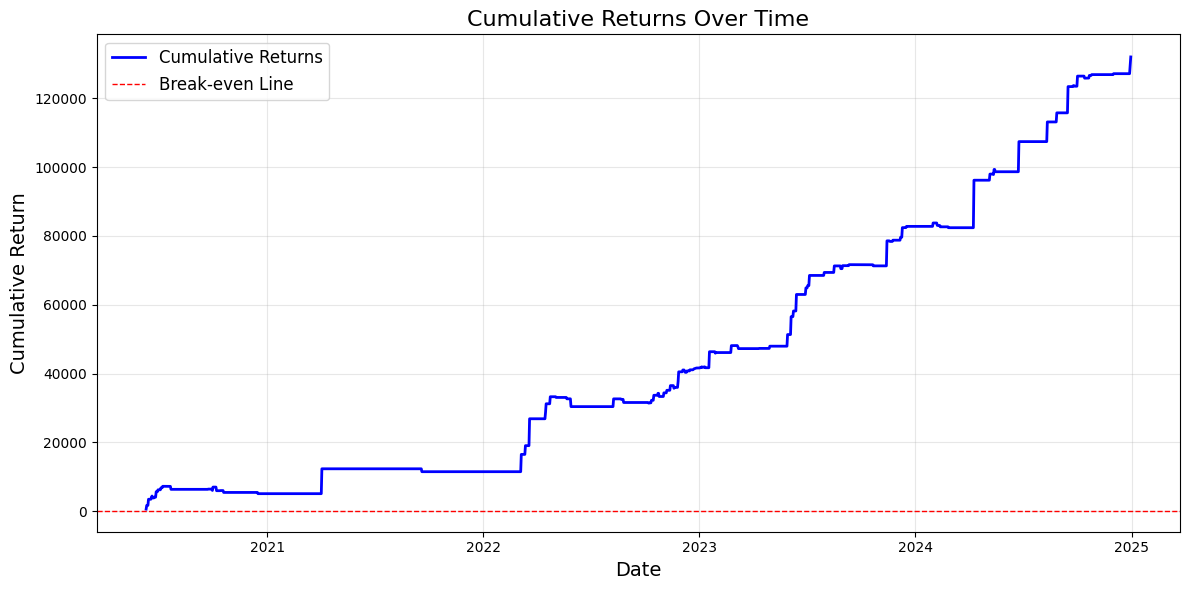

In [83]:
# Convert results to a DataFrame
data = [{'timestamp': k, 'return': v['return']} for k, v in results.items()]
df = pd.DataFrame(data)

# Convert timestamp to datetime and sort
df['datetime'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values('datetime')

# Calculate cumulative returns
df['cumulative_return'] = df['return'].cumsum()

# Generate a complete date range
full_range = pd.date_range(start=df['datetime'].min(), end=df['datetime'].max(), freq='D')

# Align the DataFrame to the complete date range and forward-fill missing values
df = df.set_index('datetime').reindex(full_range).ffill().reset_index()
df.rename(columns={'index': 'datetime'}, inplace=True)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df['datetime'], df['cumulative_return'], label='Cumulative Returns', color='blue', linewidth=2)
plt.axhline(0, color='red', linestyle='--', linewidth=1, label='Break-even Line')
plt.title('Cumulative Returns Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Cumulative Return', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

And here ends the first part of this work, for things to do before modeling volatility and getting predictions instead of following patterns:<br><br>
- Change look ahead period (right now returns are with a 48h).
- Change option limit selection (right now at 5%)
- Change every discretionary variable.<br><br>

This is the modeling of the returns of the strategy, there could be better returns if something changes, but one has to bee aware of the risk he is running into with this strategy, for starters, it doesn't do well in uncertainty periods, just calm periods, as we see at the start of 2024. There may be months without operations, volatility doesn't have to be low, we've set the scale at the 20 percentile, maybe a lower it works better, maybe not, lower scale means less trades, and viceversa. And, the biggest problem of all, data. For testing I've had 100 operations, over 4 years, that is nothing, but that's how this market works, 4 years ago nor brokers not financial institutions were using options on cryptocurrencies, that's why one can find alpha here, because there is arbitrage left to be done, that's the base of this operation.<br><br>
Of course there is room for improvement, we could've left some trades off the table with a couple of rules more, ones I would have liked to introduce, but those maybe would have hurted the scarce data I already had, so I prefered not to, maybe I could have avoided that $-3.000$€ trade at the start of 2024, maybe not, maybe operations the first month of each year are better being avoided, all of this are the ideas that need testing, here we have the first results, the first sign of viability.

In [84]:
portfolio_start = 10000

ann_return = ((portfolio / portfolio_start) ** (1/5)) - 1

ann_return

0.7000316773251407

In [85]:
risk_free_rate_annual = 0.00  # e.g., 3% annual risk-free rate
trading_days_per_year = 252  # Approximate trading days in a year

# Step 1: Convert dictionary to DataFrame
returns_df = pd.DataFrame(data)
returns_df["timestamp"] = pd.to_datetime(returns_df["timestamp"])

# Step 2: Resample or Aggregate (optional, depends on your strategy)
returns_df.set_index("timestamp", inplace=True)
returns_df = returns_df.sort_index()

# Step 3: Compute statistics
mean_return = returns_df["return"].mean()
std_dev = returns_df["return"].std()

# Step 4: Scale risk-free rate to match the frequency of returns
returns_per_year = len(returns_df) / 4  # Adjust for 4 years of data
risk_free_rate_scaled = risk_free_rate_annual / trading_days_per_year * returns_per_year

# Step 5: Sharpe Ratio
sharpe_ratio = (mean_return - risk_free_rate_scaled) / std_dev

# Output
print(f"Mean Return: {mean_return}")
print(f"Standard Deviation: {std_dev}")
print(f"Sharpe Ratio: {sharpe_ratio}")

Mean Return: 1137.9218026066465
Standard Deviation: 2319.593750232481
Sharpe Ratio: 0.49056943807190306


In [86]:
data

[{'timestamp': 1591776000000, 'return': 596.6267039039968},
 {'timestamp': 1591862400000, 'return': 1072.510437626001},
 {'timestamp': 1592121600000, 'return': 1794.9405693600042},
 {'timestamp': 1592553600000, 'return': 585.2904006427985},
 {'timestamp': 1592640000000, 'return': 352.7759636799965},
 {'timestamp': 1592726400000, 'return': -555.2666661252013},
 {'timestamp': 1592985600000, 'return': 221.02394184600018},
 {'timestamp': 1593244800000, 'return': 1594.3921497259958},
 {'timestamp': 1593504000000, 'return': 531.6588052919969},
 {'timestamp': 1593590400000, 'return': 16.289277778799715},
 {'timestamp': 1593936000000, 'return': 576.5917379376019},
 {'timestamp': 1594195200000, 'return': 439.9314938679996},
 {'timestamp': 1594800000000, 'return': -20.83836134800123},
 {'timestamp': 1595404800000, 'return': -862.2704276059984},
 {'timestamp': 1600848000000, 'return': 69.15850269279917},
 {'timestamp': 1601452800000, 'return': -390.0026513973027},
 {'timestamp': 1601539200000, 'r